In [1]:
%load_ext autoreload 
%autoreload 2

In [156]:
import torch 
import json 
import os 
from torch.utils.data import DataLoader
import sounddevice as sd 
import numpy as np 
import matplotlib.pyplot as plt 

import model 
import dataset 

from transformers import AutoModel, AutoProcessor, SpeechT5HifiGan, SpeechT5ForTextToSpeech, SpeechT5Processor
from speechbrain.pretrained import EncoderClassifier
from datasets import load_dataset 
import torchaudio
import librosa
import torch.nn.functional as F 

device = 'cpu'

In [54]:
class Attr(dict): 
  def __init__(self, *args, **kwargs): 
    super(Attr, self).__init__(*args, **kwargs) 
    self.__dict__ = self

with open('config.json', 'rb') as file: 
  config = json.load(file)
config = Attr(config)

In [76]:
gen = model.generator(config)

gen.load_state_dict(torch.load('/mnt/sda1/hyperion_models/hifigan_models/gen_model'))
gen.eval()
'success'

'success'

In [77]:
processor = SpeechT5Processor.from_pretrained("../../hf_models/speecht5_tts")
tts_model = SpeechT5ForTextToSpeech.from_pretrained("../../hf_models/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("../../hf_models/speecht5_hifigan")
classifier = EncoderClassifier.from_hparams(source="../../hf_models/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

In [78]:
signal, fs = torchaudio.load('../llama_tts/rose_.mp3')
assert fs == 16000
embeddings = classifier.encode_batch(signal[:, 16000*0:16000*9]).mean(dim=0)

In [121]:
# text = 'No, what is this?'
text = '''What's up everyone we're Blackpink and we just had an interview on the Zack Zhang'''
inputs = processor(text=text, return_tensors='pt')
with torch.no_grad(): 
  speech = tts_model.generate_speech(inputs["input_ids"], embeddings)

In [84]:
with torch.no_grad(): 
  audio = gen(speech.unsqueeze(0).transpose(2, 1))

In [90]:
audio.shape

torch.Size([1, 1, 19968])

In [89]:
sd.play(audio.squeeze(0).transpose(1, 0).view(-1).detach().numpy(), samplerate=16000)

In [88]:
sd.play(audio[0, 0].detach().numpy(), samplerate=16000)

In [83]:
sd.play(vocoder(speech).detach().numpy(), samplerate=16000)

In [ ]:
mel = mel_spectrogram(audio, self.n_fft, self.num_mels, 
                            self.sampling_rate, self.hop_size, self.win_size, 
                            self.fmin, self.fmax, center=False) 

In [94]:
config.n_fft, config.num_mels, 16000, config.hop_size, config.win_size, config.fmin, config.fmax

(1024, 80, 16000, 256, 1024, 0, 8000)

In [96]:
inp.shape

(6006910,)

In [192]:
inp_audio, _ = librosa.load('../llama_tts/rose_.mp3', sr=16000)
inp = dataset.mel_spectrogram(torch.from_numpy(inp_audio)[:16000*5].unsqueeze(0), config.n_fft, config.num_mels, 16000, config.hop_size, config.win_size, config.fmin, config.fmax, center=False)
inp.shape

torch.Size([312, 80, 1])

In [116]:
o = gen(inp.permute(2, 1, 0))

In [176]:
10**-11.5129, 10**-2.3270

(3.069728738183665e-12, 0.004709773263969529)

In [177]:
np.log10(0.0047)

-2.3279021420642825

In [191]:
inp.squeeze(-1).shape

torch.Size([312, 80])

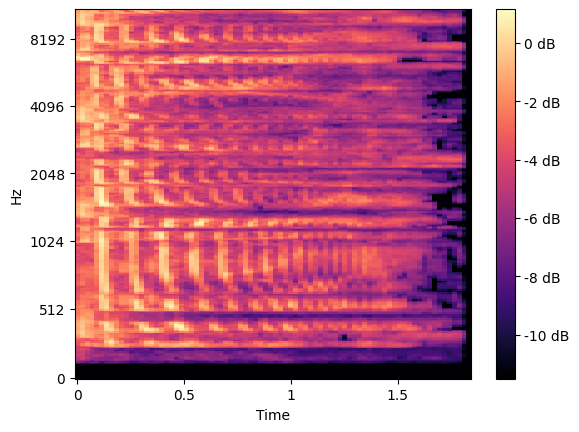

In [188]:
fig, ax = plt.subplots() 
img = librosa.display.specshow(inp.squeeze(-1).numpy(), y_axis='mel', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format='%.f dB')

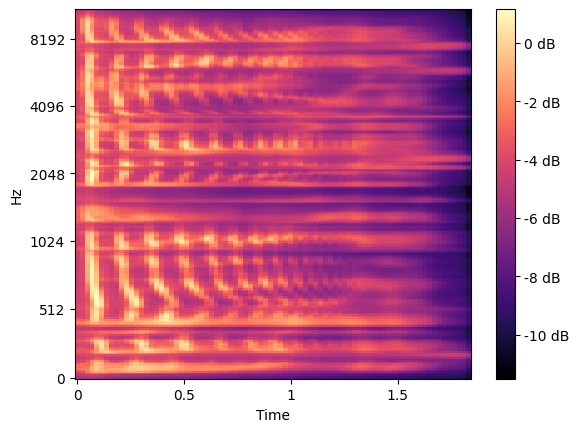

In [189]:
fig, ax = plt.subplots() 
librosa.display.specshow(speech.numpy(), y_axis='mel', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format='%.f dB')

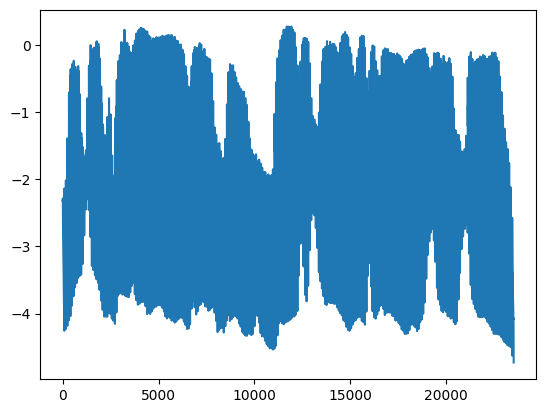

In [159]:
plt.plot(speech.view(-1))

In [120]:
sd.play(o[0, 0].detach().numpy(), samplerate=16000)

In [ ]:
x_stft = librosa.stft(audio, n_fft=fft_size, hop_length=hop_size,
                          win_length=win_length, window=window, pad_mode="reflect")
    spc = np.abs(x_stft).T  # (#frames, #bins)

    # get mel basis
    fmin = 0 if fmin is None else fmin
    fmax = sampling_rate / 2 if fmax is None else fmax
    mel_basis = librosa.filters.mel(sr=sampling_rate, n_fft=fft_size, n_mels=num_mels, fmin=fmin, fmax=fmax)

    return np.log10(np.maximum(eps, np.dot(spc, mel_basis.T)))

In [199]:
x_stft = librosa.stft(inp_audio[:16000*5], n_fft=1024, hop_length=256, win_length=None, window='hann', pad_mode='reflect')
spc = np.abs(x_stft).T
fmin, fmax = 80, 7600
mel_basis = librosa.filters.mel(sr=16000, n_fft=1024, n_mels=80, fmin=fmin, fmax=fmax)
their_output = np.log10(np.maximum(1e-10, np.dot(spc, mel_basis.T)))

In [217]:
their_output[100]

array([-0.6060139 , -1.0732986 , -0.42969412,  0.15626985, -0.62665135,
       -1.1204379 , -1.2023565 , -1.0748513 , -0.68121755, -0.1418801 ,
       -0.44799718, -1.3577721 , -1.5030361 , -0.99832445, -0.7030124 ,
        0.20439504,  0.09512337, -1.1651864 , -1.8281468 , -1.4602008 ,
       -1.1916388 , -0.31459638, -0.3560723 , -1.2232519 , -1.6653863 ,
       -1.6851524 , -1.5942067 , -0.50790393, -0.647212  , -1.5501537 ,
       -1.6580675 , -1.7867123 , -1.3830546 , -1.4405226 , -1.8411326 ,
       -1.8774894 , -1.2905387 , -0.9901544 , -1.3775684 , -1.5962514 ,
       -0.9591737 , -0.9010818 , -1.5602267 , -0.80697906, -1.1153369 ,
       -1.92436   , -1.1272833 , -1.5897125 , -1.7529528 , -1.4216248 ,
       -1.9862913 , -1.4021524 , -1.834082  , -1.5027815 , -1.5774899 ,
       -1.0550321 , -1.3731145 , -1.894291  , -1.8956609 , -1.9028274 ,
       -2.278009  , -1.8023926 , -1.8699875 , -1.8728108 , -1.574872  ,
       -1.8599119 , -1.9030005 , -1.9987838 , -2.0445502 , -2.04

In [218]:
inp.squeeze(-1)[100]

tensor([ -2.9469,  -1.5960,  -1.3270,  -2.4804,  -1.0019,   0.2602,  -1.7221,
         -2.3054,  -2.7291,  -2.1986,  -1.1731,  -0.3835,  -1.5760,  -3.4221,
         -3.0028,  -2.2170,  -0.2705,   0.6020,  -1.5605,  -4.3002,  -3.3397,
         -3.0132,  -0.9047,  -0.5520,  -2.8352,  -3.5331,  -3.7678,  -3.4231,
         -1.1027,  -1.7470,  -3.3327,  -3.7960,  -4.2550,  -2.9140,  -3.8799,
         -4.4788,  -4.4491,  -2.5656,  -3.6705,  -4.1592,  -2.9285,  -2.2928,
         -3.4605,  -2.1425,  -1.9538,  -4.5551,  -2.6476,  -3.2760,  -3.9601,
         -3.2244,  -4.3603,  -3.0849,  -4.0805,  -3.1956,  -3.6306,  -2.2592,
         -3.8839,  -4.4140,  -4.3804,  -4.7407,  -4.5322,  -4.4359,  -4.4963,
         -3.6619,  -4.1646,  -4.3815,  -4.4628,  -4.7645,  -4.6868,  -4.6020,
         -4.7386,  -4.9139,  -6.2041,  -7.5150,  -9.8707, -11.5129, -11.5129,
         -8.8854, -10.7562, -11.5129])